<a href="https://colab.research.google.com/github/Dominic-DallOsto/translational-neuromodelling-mdd/blob/master/Classifier/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Classifying MDD Patients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from google.colab import drive
from scipy.io import loadmat
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# mount your google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root_path = "/content/drive/MyDrive/translational-neuromodelling-mdd/"
A_mat_dir = "A_mats/"
corr_dir = "corr/"

# Get a list for .mat files in current folder
# Choose A_mat_dir for rDCM output, or corr_dir for correlation components
mat_files = os.listdir(root_path + A_mat_dir)

# Import patient info
participants = pd.read_table(root_path + 'participants.tsv')
participants = participants.dropna()

# Pair orders
#order = np.loadtxt(root_path + "Dataset Analysis/COI_pairs.txt")

# List for stroring all the data and labels
X = []
y = []
mdd = []
control = []

# Iterate mat files
for i, fname in enumerate(mat_files):
    # Load mat file data into data.
    data = loadmat(root_path + A_mat_dir + fname)
    id = int(os.path.basename(fname).split('.')[0][-4:]) - 1

    # Append data to the list
    X.append(data["A"])

    # Append diag label
    if participants["diag"][int(id)] == 2: # MDD
      print(i, "mdd")
      y.append(0)
      mdd.append(data["A"])
    elif participants["diag"][int(id)] == 0: # control
      print(i, "control")
      y.append(1)
      control.append(data["A"])
    else:
      print("ID: ", id)
      print("Diag: ", participants["diag"][int(id)])

0 control
1 mdd
2 control
3 mdd
4 control
5 control
6 mdd
7 mdd
8 control
9 control
10 mdd
11 mdd
12 mdd
13 mdd
14 mdd
15 control
16 control
17 mdd
18 mdd
19 mdd
20 mdd
21 control
22 control
23 mdd
24 mdd
25 mdd
26 mdd
27 mdd
28 control
29 control
30 control
31 mdd
32 control
33 control
34 control
35 control
36 mdd
37 control
38 mdd
39 mdd
40 mdd
41 control
42 mdd
43 mdd
44 mdd
45 control
46 mdd
47 control
48 control
49 mdd
50 mdd
51 mdd
52 mdd
53 control
54 mdd
55 mdd
56 control
57 control
58 control
59 mdd
60 mdd
61 control
62 mdd
63 mdd
64 control
65 control
66 mdd
67 mdd
68 control
69 control
70 mdd
71 mdd
72 mdd
73 control
74 mdd
75 control
76 control
77 mdd
78 control
79 mdd
80 control
81 mdd
82 mdd
83 mdd
84 mdd
85 mdd
86 mdd
87 mdd
88 mdd
89 mdd
90 mdd
91 control
92 control
93 control
94 control
95 control
96 control
97 control
98 mdd
99 control
100 control
101 control
102 control
103 control
104 control
105 mdd
106 control
107 control
108 mdd
109 control
110 control
111 mdd
11

In [5]:
X[0].shape

(377, 377)

In [6]:
X = np.array(X) # Convert list of X into numpy array
nsamples, nx, ny = X.shape
X_flat = X.reshape((nsamples,nx*ny)) # Convert 3D matrix to 2D input vector
X_train = X_flat[:100]
X_test = X_flat[100:]
y_train = y[:100]
y_test = y[100:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


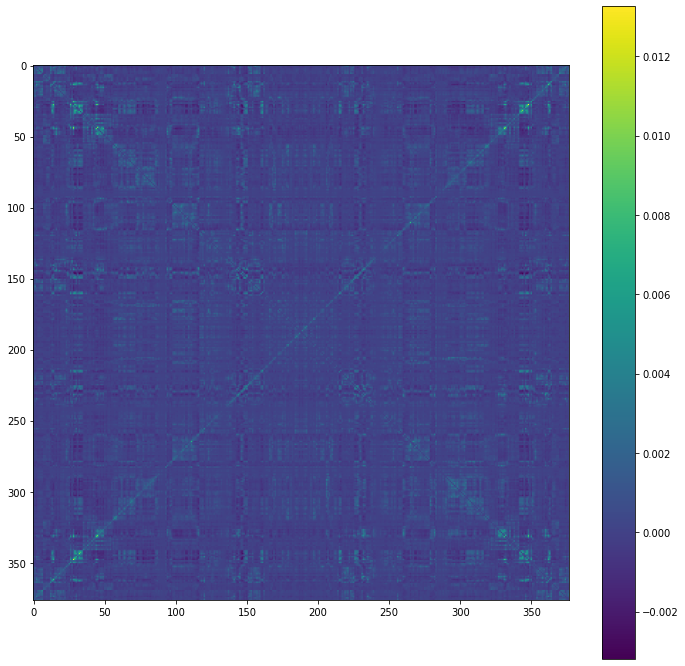

In [29]:
corr_plot = np.mean(mdd, axis=0)
corr_plot[np.diag_indices_from(np.array(corr_plot))] = 0
tfig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(corr_plot)
ax.set_aspect('equal')
plt.colorbar(orientation='vertical')
plt.show()

## Lasso

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent. For this reason Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero coefficients

In [ ]:
from sklearn import linear_model

In [ ]:
# Run CV on Lasso classifier for alpha parameter optimisation
# Source: https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py

alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{'alpha': alphas}]
n_folds = 5
lasso = linear_model.Lasso(random_state=0, max_iter=10000)
clf = GridSearchCV(lasso, param_grid=tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

(0.0001, 0.31622776601683794)

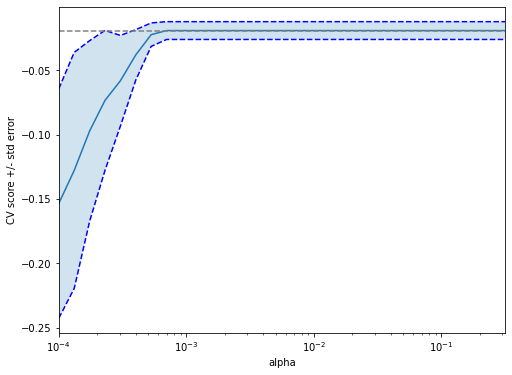

In [ ]:
# Plot the CV results

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [ ]:
clf = linear_model.Lasso(alpha=10e-1, max_iter=10000)
clf.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
clf.score(X_test, y_test)

-0.0439314285714285

## Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
clf.score(X_test, y_test)

0.3333333333333333

In [41]:
data = {'Real':  y_test,
        'Pred': preds}

df = pd.DataFrame (data, columns = ['Real','Pred'])

print (df)

    Real  Pred
0      1     0
1      1     0
2      1     1
3      1     0
4      1     0
5      0     0
6      1     0
7      1     0
8      0     0
9      1     0
10     1     0
11     0     0
12     1     1
13     1     0
14     0     0
15     1     0
16     1     0
17     0     0
18     1     0
19     1     0
20     0     0
21     1     0
22     1     0
23     1     0


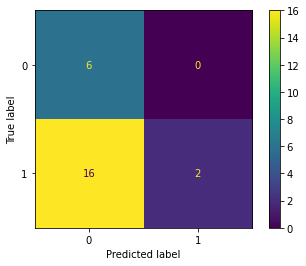

In [42]:
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot() 

## CNN

Following this tutorial: https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [10]:
train = ImageDataGenerator()
test = ImageDataGenerator()

train_dataset = train.flow_from_directory("C:/Users/ksbal/Desktop/CodeBasicML/PetImages/Train/",
                                          target_size=(150,150),
                                          batch_size = 32,
                                          class_mode = 'binary')
                                         
test_dataset = test.flow_from_directory("C:/Users/ksbal/Desktop/CodeBasicML/PetImages/Test/",
                                          target_size=(150,150),
                                          batch_size =32,
                                          class_mode = 'binary')

FileNotFoundError: ignored

In [12]:
# Check your encoded class labels
test_dataset.class_indices

NameError: ignored

In [29]:
model = keras.Sequential()

# Convolutional layer and maxpool layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(377,377,1)))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 3
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# Convolutional layer and maxpool layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
model.add(keras.layers.MaxPool2D(2,2))

# This layer flattens the resulting image array to 1D array
model.add(keras.layers.Flatten())

# Hidden layer with 512 neurons and Rectified Linear Unit activation function 
model.add(keras.layers.Dense(512,activation='relu'))

# Output layer with single neuron which gives 0 for MDD or 1 for Control
#Here we use sigmoid activation function which makes our model output to lie between 0 and 1
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [30]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 375, 375, 32)      320       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 187, 187, 32)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 185, 185, 64)      18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 92, 92, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 90, 90, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 43, 43, 128)      

In [32]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
cnn_train = X[:100]
cnn_test = X[100:]

In [34]:
cnn_train.shape

(100, 377, 377)

In [38]:
#steps_per_epoch = train_imagesize/batch_size

model.fit(cnn_train[...,None],
         np.array(y_train),
         steps_per_epoch = 25,
         epochs = 10)

Epoch 1/10
25/25 [==============================] - 25s 978ms/step - loss: 0.6859 - accuracy: 0.5600
Epoch 2/10
25/25 [==============================] - 24s 977ms/step - loss: 0.6862 - accuracy: 0.5600
Epoch 3/10
25/25 [==============================] - 25s 981ms/step - loss: 0.6863 - accuracy: 0.5600
Epoch 4/10
25/25 [==============================] - 24s 979ms/step - loss: 0.6863 - accuracy: 0.5600
Epoch 5/10
25/25 [==============================] - 24s 976ms/step - loss: 0.6860 - accuracy: 0.5600
Epoch 6/10
25/25 [==============================] - 25s 980ms/step - loss: 0.6861 - accuracy: 0.5600
Epoch 7/10
25/25 [==============================] - 25s 984ms/step - loss: 0.6867 - accuracy: 0.5600
Epoch 8/10
25/25 [==============================] - 24s 978ms/step - loss: 0.6860 - accuracy: 0.5600
Epoch 9/10
25/25 [==============================] - 24s 977ms/step - loss: 0.6862 - accuracy: 0.5600
Epoch 10/10
25/25 [==============================] - 24s 973ms/step - loss: 0.6861 - accura

In [43]:
preds = model.predict(cnn_test[...,None])

In [46]:
print(preds)

[[0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]
 [0.44408107]]
